Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [2]:
# Read in the data sets
df_large = pd.read_csv("data/nat2019us.csv")

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df_large.sample(n=200000, random_state=42, axis=0)

In [4]:
df.columns

Index(['dob_yy', 'dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'f_facility',
       'bfacil3', 'mage_impflg', 'mage_repflg', 'mager',
       ...
       'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos',
       'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed'],
      dtype='object', length=226)

In [5]:
df.head()

,dob_yy,dob_mm,dob_tt,dob_wk,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,...,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen,itran,ilive,bfed,f_bfed
2837169,2019,12,1041,6,1,1,1,NaN,NaN,22,...,1,1,1,1,1,1,N,Y,Y,1
97459,2019,11,1108,6,1,1,1,NaN,NaN,30,...,1,1,1,1,1,1,N,Y,N,1
572923,2019,11,1518,5,1,0,1,NaN,NaN,38,...,1,1,1,1,1,1,N,Y,U,0
1665659,2019,10,942,7,1,1,1,NaN,NaN,35,...,1,1,1,1,1,1,N,Y,Y,1
2184476,2019,5,950,6,1,1,1,NaN,NaN,38,...,1,1,1,1,1,1,N,N,N,1


Columns are removed for the following reasons:
- They are storing metadata about the collection of the data minor processing tasks performed
- They are pre-binned for a specific purpose outside the scope of this analysis
- They are slight variations of existing columns which are more applicable to this analysis
- They represent events that happen after birth has already occurred

In [6]:
remove = ['dob_yy', 'f_facility', 'bfacil3', 'mage_impflg', 'mage_repflg', 'mager14', 'mager9', 'mrace31', 'mrace6', 'mrace15',
           'mraceimp', 'mhispx', 'f_mhisp', 'mracehisp', 'mar_p', 'mar_imp', 'f_mar_p', 'f_meduc', 'fagerpt_flg', 'fagerec11',
           'frace31', 'frace15', 'fhispx', 'f_fhisp', 'lbo_rec', 'tbo_rec', 'illb_r', 'illb_r11', 'ilop_r',
           'ilop_r11', 'ilp_r11', 'f_mpcb', 'precare5', 'previs_rec', 'f_tpcv', 'f_wic', 'cig0_r', 'cig1_r', 'cig2_r',
           'cig3_r', 'f_cigs_0', 'f_cigs_1', 'f_cigs_2', 'f_cigs_3', 'cig_rec', 'f_tobaco', 'f_m_ht', 'bmi_r', 'pwgt_r',
           'f_pwgt', 'f_dwgt', 'wtgain_rec', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 
           'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inf_drg', 'f_rf_inf_art', 'rf_cesar', 'f_rf_cesar', 'f_rf_ncesar',
           'no_risks', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'no_infec', 'ob_ecvs', 'ob_ecvf',
           'f_ob_succ', 'f_ob_fail', 'ld_indl', 'ld_augm', 'ld_anes', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb',
           'f_ld_chor', 'f_ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial', 'f_me_pres', 'f_me_rout', 'f_me_trial',
           'rdmeth_rec', 'dmeth_rec', 'f_dmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'f_mm_mtr',
           'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'no_mmorb', 'mtran', 'pay', 'f_pay', 'f_pay_rec', 'apgar5r',
           'f_apgar5', 'apgar10', 'apgar10r', 'imp_plur', 'setorder_r', 'imp_sex', 'dlmp_mm', 'dlmp_yy', 'compgst_imp',
           'obgest_flg', 'gestrec10', 'gestrec3', 'lmpused', 'oegest_comb', 'oegest_r10', 'dbwt', 'bwtr12', 'bwtr4',
           'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'f_ab_vent', 'f_ab_vent6',
           'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 
           'ca_gast', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'ca_limb',
           'ca_cleft', 'ca_clpal', 'ca_disor', 'ca_hypo', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 
           'f_ca_chrom', 'f_ca_hypos', 'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed', 'f_mm_', 'f_ab_nicu', 'fracehisp',
           'oegest_r3', 'dob_mm', 'dob_tt', 'dob_wk', 'restatus', 'frace6', 'fhisp_r', 'feduc', 'ilp_r', 'attend', 'pay_rec']

In [7]:
df.drop(remove, axis=1, inplace=True)
df.columns

Index(['bfacil', 'mager', 'mbstate_rec', 'mbrace', 'mhisp_r', 'dmar', 'meduc',
       'fagecomb', 'priorlive', 'priordead', 'priorterm', 'precare', 'previs',
       'wic', 'cig_0', 'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'bmi', 'dwgt_r',
       'wtgain', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
       'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesarn', 'ip_gon',
       'ip_syph', 'ip_chlam', 'ip_hepatb', 'ip_hepatc', 'ld_ster', 'ld_antb',
       'ld_chor', 'apgar5', 'dplural', 'sex', 'combgest', 'ca_downs'],
      dtype='object')

In [8]:
rename = ['birth_place', 'mother_age', 'mother_native',
          'mother_race', 'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
          'living_children', 'deceased_children', 'terminations', 
          'months_prenatal_care', 'prenatal_visits', 'food_assistance', 'prepregnancy_daily_cig',
          'first_tri_daily_cig', 'second_tri_daily_cig', 'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
          'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension', 'gestational_hypertension', 'eclampsia',
          'previous_premature_birth', 'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
          'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
          'chorioamnionitis', 'apgar_score', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
          'down_syndrome']

In [9]:
df.columns = rename

## Target Engineering

In [10]:
df['apgar_score'].value_counts()

9     164788
8      21975
7       4213
10      4096
6       1654
5        859
99       754
4        485
1        387
3        331
2        329
0        129
Name: apgar_score, dtype: int64

In [11]:
df['apgar_score'].replace(to_replace=list(range(0, 7)), value=0, inplace=True)

In [12]:
df['apgar_score'].replace(to_replace=list(range(7, 11)), value=1, inplace=True)

In [13]:
df.drop(df.loc[df['apgar_score']==99].index, inplace=True)

In [14]:
df['apgar_score'].value_counts()

1    195072
0      4174
Name: apgar_score, dtype: int64

## Feature Processing

In [15]:
df.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'apgar_score', 'plural_pregnancy', 'infant_sex',
       'weeks_gestation', 'down_syndrome'],
      dtype='object')

In [16]:
df['birth_place'].value_counts()

1    196385
3      1411
2      1032
4       141
5       128
7       109
6        34
9         6
Name: birth_place, dtype: int64

In [17]:
df['birth_place'].replace(to_replace=list(range(2, 8)), value="other", inplace=True)
df['birth_place'].replace(to_replace=1, value="hospital", inplace=True)
df['birth_place'].replace(to_replace=9, value=np.nan, inplace=True)

In [18]:
df['mother_native'].value_counts()

1    153733
2     45101
3       412
Name: mother_native, dtype: int64

In [19]:
df['mother_native'].replace(to_replace=2, value=0, inplace=True)
df['mother_native'].replace(to_replace=3, value=np.nan, inplace=True)

In [20]:
df['mother_race'].value_counts()

1    148807
2     33377
4     14876
3      2186
Name: mother_race, dtype: int64

In [21]:
df['mother_race'].replace({1: 'white', 2: 'black', 3: 'native_american', 4: 'asian/pi'}, inplace=True)

In [22]:
# Place of birth
counts = (df[['mother_race', 'apgar_score']]
              .groupby(['mother_race', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

In [23]:
counts['percent_low_apgar'] = (counts[0]/counts[1])*100

In [24]:
counts['percent_low_apgar']

mother_race
asian/pi           1.618963
black              3.238478
native_american    2.292934
white              1.946344
Name: percent_low_apgar, dtype: float64

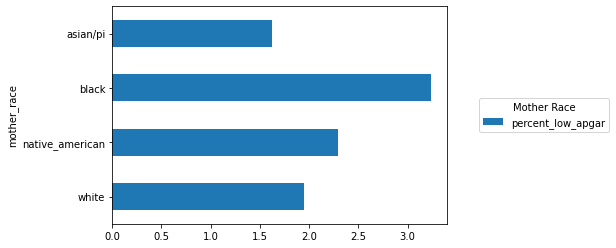

In [25]:
ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Mother Race'
)

In [26]:
df['mother_hispanic'].value_counts()

0    149933
1     26752
4      8818
5      6930
2      3718
9      1842
3      1253
Name: mother_hispanic, dtype: int64

In [27]:
df['mother_hispanic'].replace(to_replace=list(range(1, 6)), value=1, inplace=True)
df['mother_hispanic'].replace(to_replace=9, value=np.nan, inplace=True)

In [28]:
df['marital_status'].value_counts()

1.0    105025
2.0     70611
Name: marital_status, dtype: int64

In [29]:
df['marital_status'].replace({1: 'married', 2: 'unmarried'}, inplace=True)

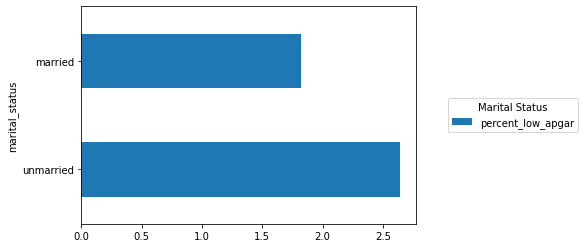

In [30]:
counts = (df[['marital_status', 'apgar_score']]
              .groupby(['marital_status', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Marital Status'
)

In [31]:
df['mother_education'].value_counts()

3    51297
6    41128
4    38571
7    19291
2    17847
5    16520
1     6164
8     5620
9     2808
Name: mother_education, dtype: int64

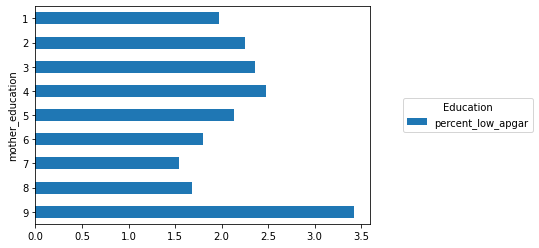

In [32]:
counts = (df[['mother_education', 'apgar_score']]
              .groupby(['mother_education', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Education'
)

In [33]:
df['mother_education'].replace(to_replace=list(range(1, 6)), value="hs_or_lower", inplace=True)
df['mother_education'].replace(to_replace=list(range(6, 9)), value="college_or_higher", inplace=True)
df['mother_education'].replace(to_replace=9, value=np.nan, inplace=True)

In [34]:
df['father_age'].value_counts()

99    22874
31    10833
30    10672
32    10581
33    10445
      ...  
82        2
13        2
77        1
78        1
86        1
Name: father_age, Length: 67, dtype: int64

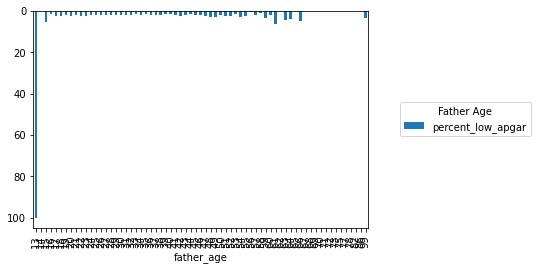

In [35]:
counts = (df[['father_age', 'apgar_score']]
              .groupby(['father_age', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Father Age'
)

In [36]:
df['father_age'].replace(to_replace=99, value=np.nan, inplace=True)

In [37]:
df['living_children'].value_counts()

0     76709
1     63176
2     34150
3     14692
4      5715
5      2398
6      1053
7       536
8       272
99      238
9       143
10       94
11       42
12       17
13        4
15        3
14        2
17        1
16        1
Name: living_children, dtype: int64

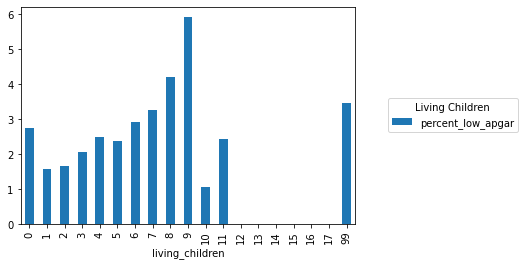

In [38]:
counts = (df[['living_children', 'apgar_score']]
              .groupby(['living_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Living Children'
)

In [39]:
df['living_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [40]:
df['deceased_children'].value_counts()

0     196540
1       1955
99       370
2        249
3         55
4         24
5         18
6         10
7          8
9          5
10         4
11         3
8          3
12         2
Name: deceased_children, dtype: int64

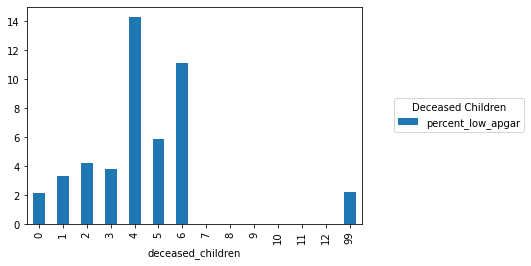

In [41]:
counts = (df[['deceased_children', 'apgar_score']]
              .groupby(['deceased_children', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Deceased Children'
)

In [42]:
df['deceased_children'].replace(to_replace=99, value=np.nan, inplace=True)

In [43]:
df['terminations'].value_counts()

0     144300
1      35375
2      12058
3       4240
4       1594
5        631
99       409
6        277
7        149
8         67
10        56
9         41
11        21
12        10
13         6
14         3
16         2
18         2
15         1
23         1
19         1
20         1
22         1
Name: terminations, dtype: int64

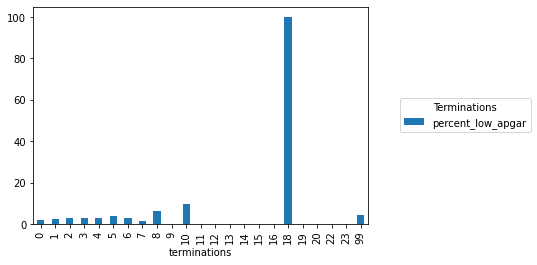

In [44]:
counts = (df[['terminations', 'apgar_score']]
              .groupby(['terminations', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Terminations'
)

In [45]:
df['terminations'].replace(to_replace=99, value=np.nan, inplace=True)

In [46]:
df['months_prenatal_care'].value_counts()

2     78290
3     61809
4     17257
1     11216
5      8589
6      5381
99     4385
7      4199
0      3488
8      3294
9      1322
10       16
Name: months_prenatal_care, dtype: int64

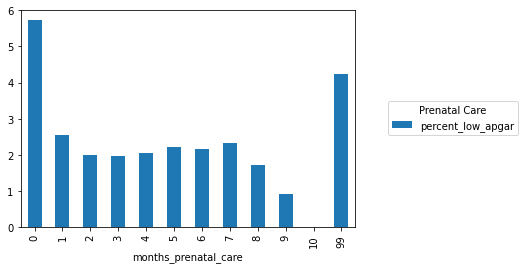

In [47]:
counts = (df[['months_prenatal_care', 'apgar_score']]
              .groupby(['months_prenatal_care', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Care'
)

In [48]:
df['months_prenatal_care'].replace(to_replace=99, value=np.nan, inplace=True)

In [49]:
df['prenatal_visits'].value_counts()

12    30538
10    25901
11    20042
13    19184
14    16184
      ...  
63        1
62        1
58        1
53        1
54        1
Name: prenatal_visits, Length: 66, dtype: int64

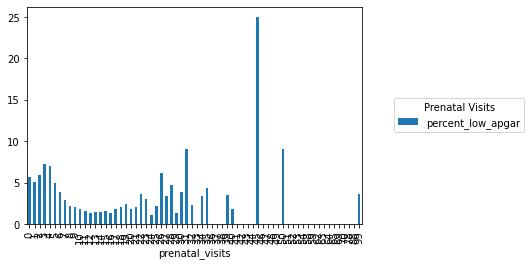

In [50]:
counts = (df[['prenatal_visits', 'apgar_score']]
              .groupby(['prenatal_visits', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Prenatal Visits'
)

In [51]:
df['prenatal_visits'].replace(to_replace=99, value=np.nan, inplace=True)

In [52]:
df['food_assistance'].value_counts()

N    130288
Y     66694
U      2264
Name: food_assistance, dtype: int64

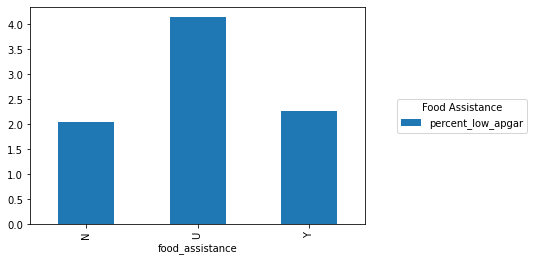

In [53]:
counts = (df[['food_assistance', 'apgar_score']]
              .groupby(['food_assistance', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [54]:
df['prenatal_visits'].replace(to_replace='U', value=np.nan, inplace=True)

In [55]:
df['prepregnancy_daily_cig'].value_counts()

0     183091
20      4556
10      4047
5       1650
99       947
3        707
2        615
4        584
1        491
6        480
40       462
15       347
7        309
30       233
8        211
12       164
60        66
9         56
98        39
25        37
11        22
13        17
80        17
18        14
14        12
35        10
16        10
50        10
24         9
21         9
22         3
45         3
90         2
19         2
48         2
84         1
72         1
17         1
70         1
27         1
28         1
32         1
34         1
36         1
55         1
65         1
23         1
Name: prepregnancy_daily_cig, dtype: int64

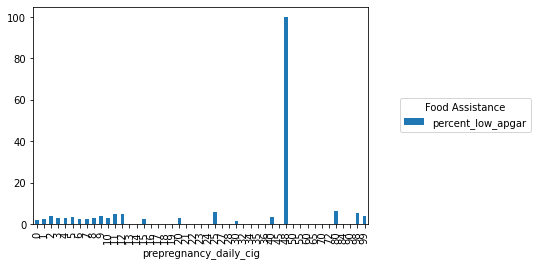

In [56]:
counts = (df[['prepregnancy_daily_cig', 'apgar_score']]
              .groupby(['prepregnancy_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Food Assistance'
)

In [57]:
df['first_tri_daily_cig'].value_counts()

0     186763
10      3605
20      2394
5       1649
99       942
3        627
2        622
4        529
1        406
6        382
15       339
7        269
8        209
40       132
12       101
30        81
9         52
60        25
98        19
11        16
14        12
25        11
18        10
16         8
80         8
17         8
13         5
21         4
35         4
50         3
24         3
22         2
45         2
19         1
90         1
41         1
55         1
Name: first_tri_daily_cig, dtype: int64

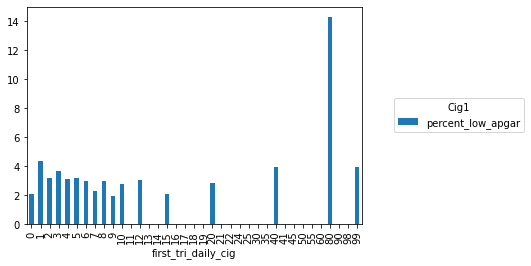

In [58]:
counts = (df[['first_tri_daily_cig', 'apgar_score']]
              .groupby(['first_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig1'
)

In [59]:
df['first_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [60]:
df['second_tri_daily_cig'].value_counts()

0     188430
10      3203
5       1710
20      1474
99       943
3        652
2        577
4        510
1        394
6        370
7        249
15       227
8        198
40        68
12        64
30        47
9         42
98        16
11        15
13        11
60         9
25         7
14         4
50         4
35         3
80         3
17         2
16         2
18         2
21         2
24         2
45         2
19         1
90         1
28         1
55         1
Name: second_tri_daily_cig, dtype: int64

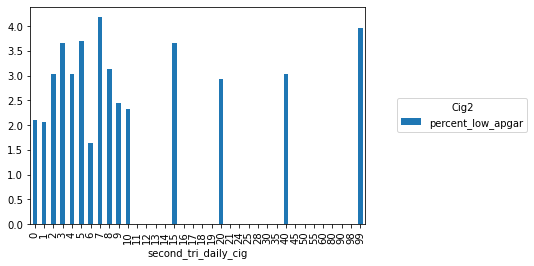

In [61]:
counts = (df[['second_tri_daily_cig', 'apgar_score']]
              .groupby(['second_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig2'
)

In [62]:
df['second_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [63]:
df['third_tri_daily_cig'].value_counts()

0     187990
10      2758
99      1944
5       1733
20      1281
3        748
2        666
4        543
1        539
6        327
7        190
8        146
15       129
40        62
12        46
30        35
9         35
98        16
11        13
60         6
13         6
50         5
16         4
25         3
35         3
18         3
14         3
17         2
19         2
21         2
45         2
90         1
24         1
55         1
80         1
Name: third_tri_daily_cig, dtype: int64

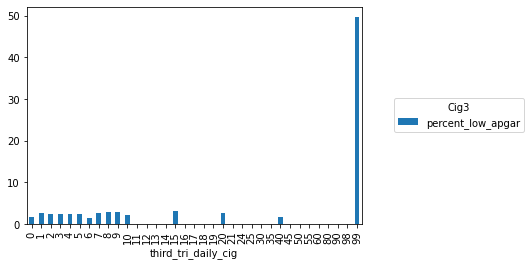

In [64]:
counts = (df[['third_tri_daily_cig', 'apgar_score']]
              .groupby(['third_tri_daily_cig', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [65]:
df['third_tri_daily_cig'].replace(to_replace=99, value=np.nan, inplace=True)

In [66]:
df['height'].value_counts()

64    29357
63    25929
62    25420
65    23594
66    21480
67    17291
61    14271
60    11087
68     9588
69     6465
59     4698
70     3160
71     1668
58     1242
57     1031
99     1006
72      717
56      363
73      232
55      159
74      127
53       72
54       70
78       46
75       29
49       29
77       25
76       20
48       20
52       18
51       16
50       12
47        1
45        1
42        1
40        1
Name: height, dtype: int64

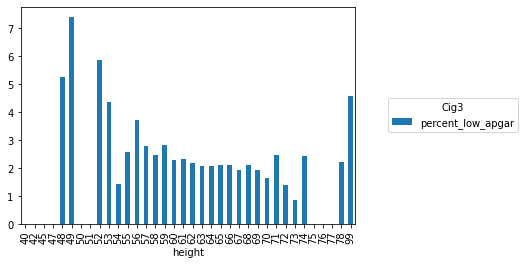

In [67]:
counts = (df[['height', 'apgar_score']]
              .groupby(['height', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [68]:
df['height'].replace(to_replace=99, value=np.nan, inplace=True)

In [69]:
df['bmi'].value_counts()

99.9    4394
26.6    3635
28.3    3272
23.0    2413
22.3    2406
        ... 
62.7       1
63.4       1
58.7       1
62.1       1
64.7       1
Name: bmi, Length: 513, dtype: int64

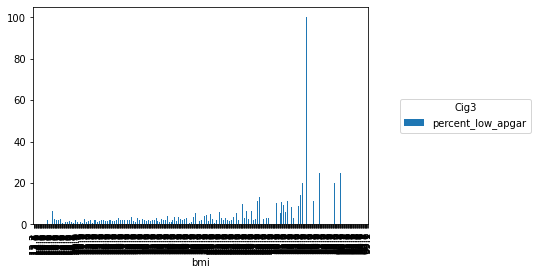

In [70]:
counts = (df[['bmi', 'apgar_score']]
              .groupby(['bmi', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [71]:
df['bmi'].replace(to_replace=99, value=np.nan, inplace=True)

In [72]:
df['delivery_weight'].value_counts()

160    3757
180    3691
170    3527
165    3052
150    3046
       ... 
397       4
391       3
392       3
394       2
399       2
Name: delivery_weight, Length: 302, dtype: int64

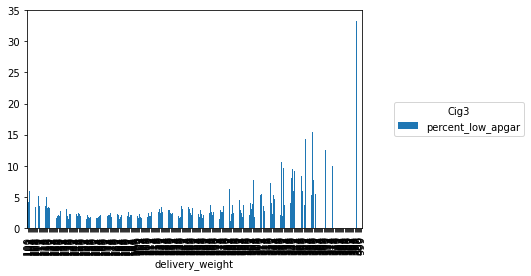

In [73]:
counts = (df[['delivery_weight', 'apgar_score']]
              .groupby(['delivery_weight', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [74]:
df['delivery_weight'].replace(to_replace=999, value=np.nan, inplace=True)

In [75]:
df['weight_gain'].value_counts()

30    8803
20    7261
25    6716
35    6084
99    5712
      ... 
92      22
97      21
96      17
93      17
94      13
Name: weight_gain, Length: 100, dtype: int64

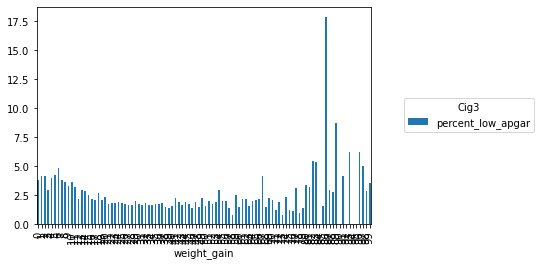

In [76]:
counts = (df[['weight_gain', 'apgar_score']]
              .groupby(['weight_gain', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [77]:
df['weight_gain'].replace(to_replace=99, value=np.nan, inplace=True)

In [78]:
df['diabetes'].value_counts()

N    197135
Y      2000
U       111
Name: diabetes, dtype: int64

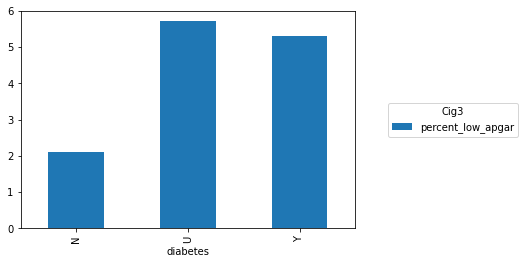

In [79]:
counts = (df[['diabetes', 'apgar_score']]
              .groupby(['diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [80]:
df['diabetes'].replace(to_replace='U', value=np.nan, inplace=True)

In [81]:
df['gestational_diabetes'].value_counts()

N    185319
Y     13816
U       111
Name: gestational_diabetes, dtype: int64

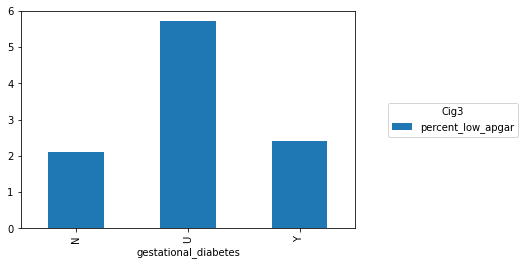

In [82]:
counts = (df[['gestational_diabetes', 'apgar_score']]
              .groupby(['gestational_diabetes', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [83]:
df['gestational_diabetes'].replace(to_replace='U', value=np.nan, inplace=True)

In [84]:
df['hypertension'].value_counts()

N    194695
Y      4440
U       111
Name: hypertension, dtype: int64

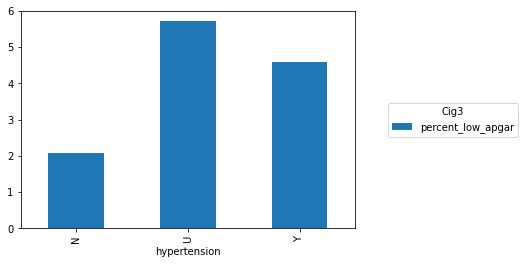

In [85]:
counts = (df[['hypertension', 'apgar_score']]
              .groupby(['hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [86]:
df['hypertension'].replace(to_replace='U', value=np.nan, inplace=True)

In [87]:
df['gestational_hypertension'].value_counts()

N    183419
Y     15716
U       111
Name: gestational_hypertension, dtype: int64

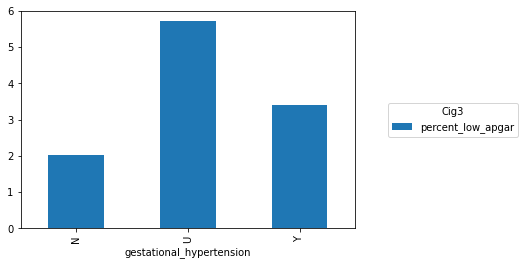

In [88]:
counts = (df[['gestational_hypertension', 'apgar_score']]
              .groupby(['gestational_hypertension', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [89]:
df['gestational_hypertension'].replace(to_replace='U', value=np.nan, inplace=True)

In [90]:
df['eclampsia'].value_counts()

N    198575
Y       560
U       111
Name: eclampsia, dtype: int64

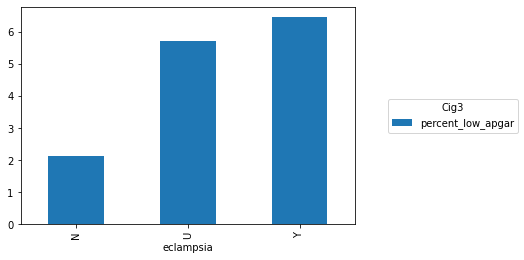

In [91]:
counts = (df[['eclampsia', 'apgar_score']]
              .groupby(['eclampsia', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Cig3'
)

In [92]:
df['eclampsia'].replace(to_replace='U', value=np.nan, inplace=True)

In [93]:
df['previous_premature_birth'].value_counts()

N    191806
Y      7329
U       111
Name: previous_premature_birth, dtype: int64

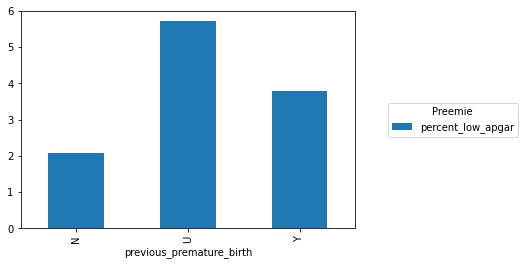

In [94]:
counts = (df[['previous_premature_birth', 'apgar_score']]
              .groupby(['previous_premature_birth', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [95]:
df['previous_premature_birth'].replace(to_replace='U', value=np.nan, inplace=True)

In [96]:
df['infertility_treatment'].value_counts()

N    195050
Y      4085
U       111
Name: infertility_treatment, dtype: int64

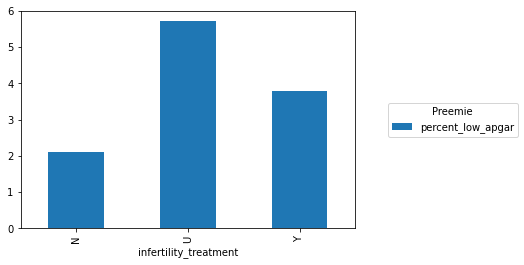

In [97]:
counts = (df[['infertility_treatment', 'apgar_score']]
              .groupby(['infertility_treatment', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [98]:
df['infertility_treatment'].replace(to_replace='U', value=np.nan, inplace=True)

In [99]:
df['fertility_drugs'].value_counts()

X    195050
N      2295
Y      1588
U       313
Name: fertility_drugs, dtype: int64

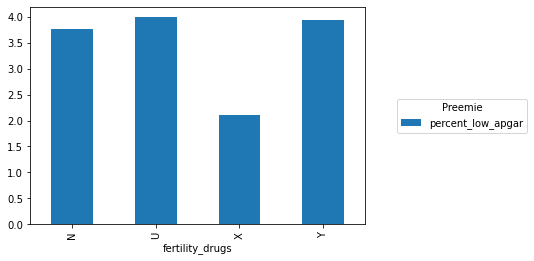

In [100]:
counts = (df[['fertility_drugs', 'apgar_score']]
              .groupby(['fertility_drugs', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [101]:
df['fertility_drugs'].replace(to_replace='U', value=np.nan, inplace=True)
df['fertility_drugs'].replace(to_replace='X', value='N', inplace=True)

In [102]:
df['assisted_reproduction'].value_counts()

X    195050
Y      2633
N      1250
U       313
Name: assisted_reproduction, dtype: int64

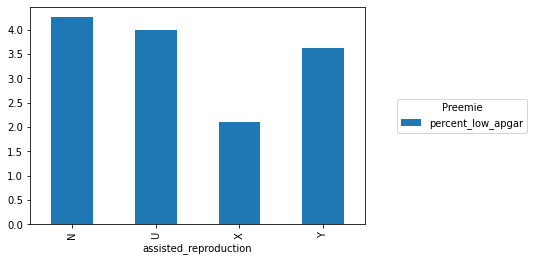

In [103]:
counts = (df[['assisted_reproduction', 'apgar_score']]
              .groupby(['assisted_reproduction', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [104]:
df['assisted_reproduction'].replace(to_replace='U', value=np.nan, inplace=True)
df['assisted_reproduction'].replace(to_replace='X', value='N', inplace=True)

In [105]:
df['previous_cesareans'].value_counts()

0     168363
1      20909
2       7286
3       1968
4        454
99       152
5         92
6         17
7          4
8          1
Name: previous_cesareans, dtype: int64

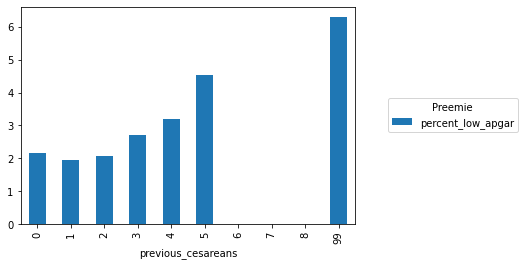

In [106]:
counts = (df[['previous_cesareans', 'apgar_score']]
              .groupby(['previous_cesareans', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [107]:
df['previous_cesareans'].replace(to_replace=99, value=np.nan, inplace=True)

In [108]:
df['gonorrhea'].value_counts()

N    198206
Y       617
U       423
Name: gonorrhea, dtype: int64

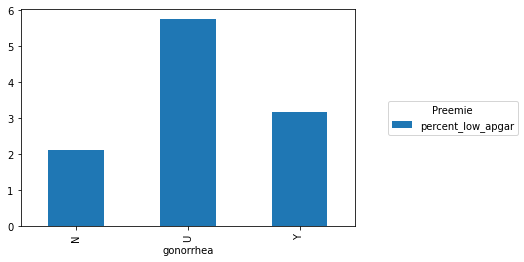

In [109]:
counts = (df[['gonorrhea', 'apgar_score']]
              .groupby(['gonorrhea', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [110]:
df['gonorrhea'].replace(to_replace='U', value=np.nan, inplace=True)

In [111]:
df['syphilis'].value_counts()

N    198547
U       423
Y       276
Name: syphilis, dtype: int64

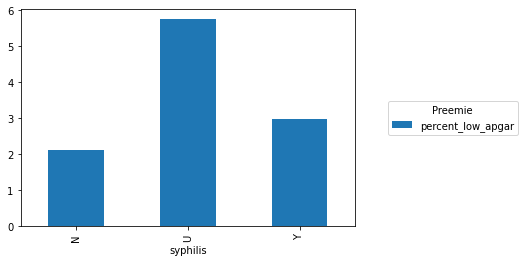

In [112]:
counts = (df[['syphilis', 'apgar_score']]
              .groupby(['syphilis', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Preemie'
)

In [113]:
df['syphilis'].replace(to_replace='U', value=np.nan, inplace=True)

In [114]:
df['chlamydia'].value_counts()

N    195113
Y      3710
U       423
Name: chlamydia, dtype: int64

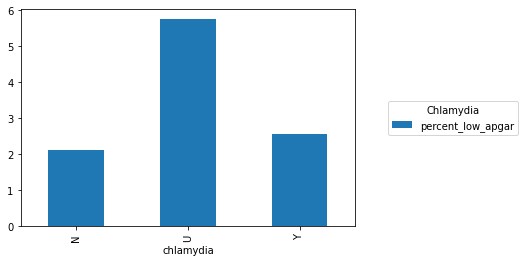

In [115]:
counts = (df[['chlamydia', 'apgar_score']]
              .groupby(['chlamydia', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Chlamydia'
)

In [116]:
df['chlamydia'].replace(to_replace='U', value=np.nan, inplace=True)

In [117]:
df['hepatitis_b'].value_counts()

N    198440
U       423
Y       383
Name: hepatitis_b, dtype: int64

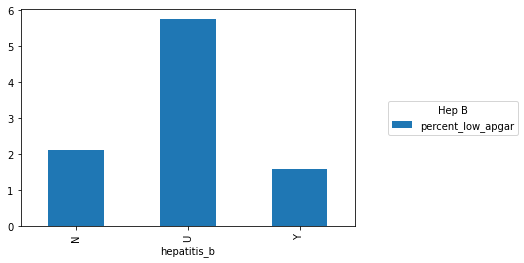

In [118]:
counts = (df[['hepatitis_b', 'apgar_score']]
              .groupby(['hepatitis_b', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Hep B'
)

In [119]:
df['hepatitis_b'].replace(to_replace='U', value=np.nan, inplace=True)

In [120]:
df['hepatitis_c'].value_counts()

N    197818
Y      1005
U       423
Name: hepatitis_c, dtype: int64

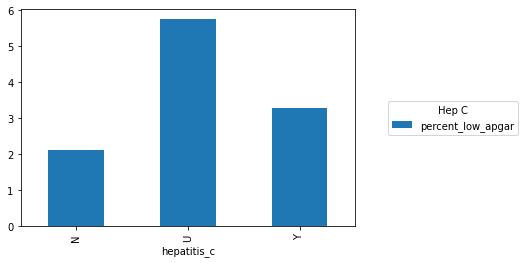

In [121]:
counts = (df[['hepatitis_c', 'apgar_score']]
              .groupby(['hepatitis_c', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Hep C'
)

In [122]:
df['hepatitis_c'].replace(to_replace='U', value=np.nan, inplace=True)

In [123]:
df['steroids'].value_counts()

N    191508
Y      7680
U        58
Name: steroids, dtype: int64

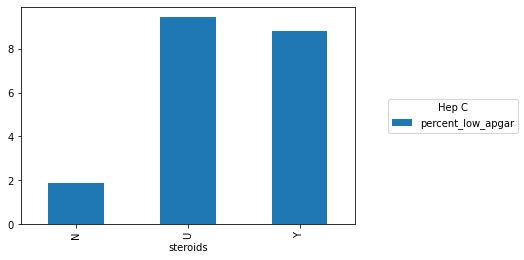

In [124]:
counts = (df[['steroids', 'apgar_score']]
              .groupby(['steroids', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Hep C'
)

In [125]:
df['steroids'].replace(to_replace='U', value=np.nan, inplace=True)

In [126]:
df['antibiotics'].value_counts()

N    148987
Y     50201
U        58
Name: antibiotics, dtype: int64

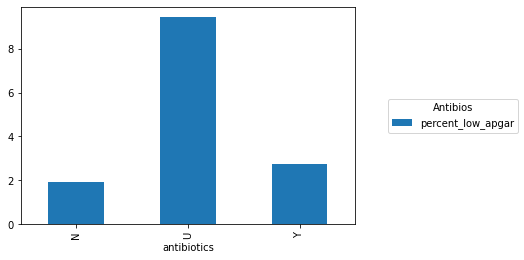

In [127]:
counts = (df[['antibiotics', 'apgar_score']]
              .groupby(['antibiotics', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='Antibios'
)

In [128]:
df['antibiotics'].replace(to_replace='U', value=np.nan, inplace=True)

In [129]:
df['chorioamnionitis'].value_counts()

N    196039
Y      3149
U        58
Name: chorioamnionitis, dtype: int64

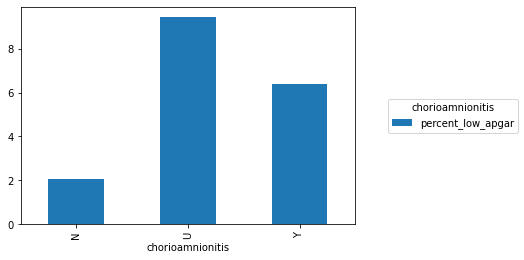

In [130]:
counts = (df[['chorioamnionitis', 'apgar_score']]
              .groupby(['chorioamnionitis', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='chorioamnionitis'
)

In [131]:
df['chorioamnionitis'].replace(to_replace='U', value=np.nan, inplace=True)

In [132]:
df['apgar_score'].value_counts()

1    195072
0      4174
Name: apgar_score, dtype: int64

In [133]:
df['plural_pregnancy'].value_counts()

1    192629
2      6444
3       167
4         4
5         2
Name: plural_pregnancy, dtype: int64

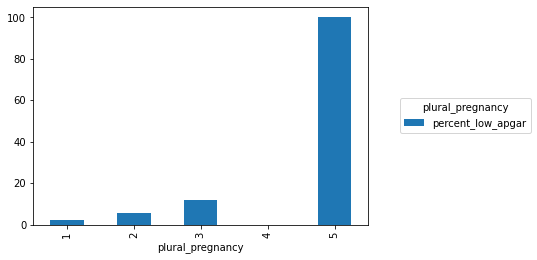

In [134]:
counts = (df[['plural_pregnancy', 'apgar_score']]
              .groupby(['plural_pregnancy', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='plural_pregnancy'
)

In [135]:
df['infant_sex'].value_counts()

M    102178
F     97068
Name: infant_sex, dtype: int64

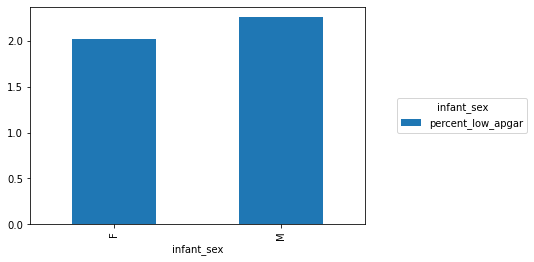

In [136]:
counts = (df[['infant_sex', 'apgar_score']]
              .groupby(['infant_sex', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='infant_sex'
)

In [137]:
df['weeks_gestation'].value_counts()

39    60951
40    36249
38    32980
37    19821
41    14724
36     9149
42     5038
35     4849
34     3309
43     2413
33     1847
44     1324
32     1262
31      872
45      703
30      698
29      492
46      412
28      401
27      305
26      275
47      267
25      214
24      174
23      147
22       96
99       78
21       72
20       49
19       42
18       21
17       12
Name: weeks_gestation, dtype: int64

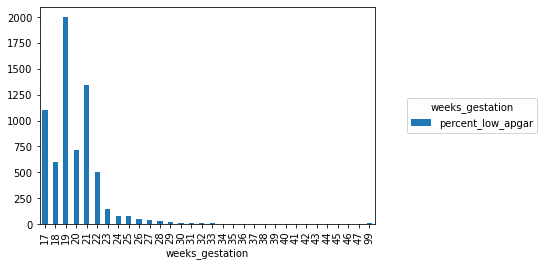

In [138]:
counts = (df[['weeks_gestation', 'apgar_score']]
              .groupby(['weeks_gestation', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='weeks_gestation'
)

In [139]:
df['weeks_gestation'].replace(to_replace=99, value=np.nan, inplace=True)

In [140]:
df['down_syndrome'].value_counts()

N    198916
U       206
C        62
P        62
Name: down_syndrome, dtype: int64

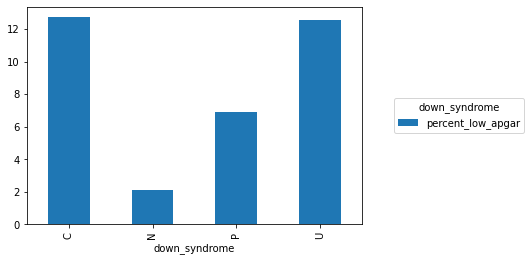

In [141]:
counts = (df[['down_syndrome', 'apgar_score']]
              .groupby(['down_syndrome', 'apgar_score'])
              .size()
              .unstack('apgar_score')
         )

counts['percent_low_apgar'] = (counts[0]/counts[1])*100

ax = counts['percent_low_apgar'].plot.bar()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.5, 0.5), 
    title='down_syndrome'
)

In [142]:
df['down_syndrome'].replace(to_replace='U', value=np.nan, inplace=True)

In [143]:
df['down_syndrome'].replace(to_replace='P', value='C', inplace=True)

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199246 entries, 2837169 to 2503356
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   birth_place               199240 non-null  object 
 1   mother_age                199246 non-null  int64  
 2   mother_native             198834 non-null  float64
 3   mother_race               199246 non-null  object 
 4   mother_hispanic           197404 non-null  float64
 5   marital_status            175636 non-null  object 
 6   mother_education          196438 non-null  object 
 7   father_age                176372 non-null  float64
 8   living_children           199008 non-null  float64
 9   deceased_children         198876 non-null  float64
 10  terminations              198837 non-null  float64
 11  months_prenatal_care      194861 non-null  float64
 12  prenatal_visits           194437 non-null  float64
 13  food_assistance           199246 non-

In [145]:
df_cat = df.select_dtypes(include=['object'])

In [146]:
df_num = df.select_dtypes(include=['int64', 'float64'])

In [147]:
for c in df_cat.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- birth_place ---
hospital    196385
other         2855
Name: birth_place, dtype: int64
---- mother_race ---
white              148807
black               33377
asian/pi            14876
native_american      2186
Name: mother_race, dtype: int64
---- marital_status ---
married      105025
unmarried     70611
Name: marital_status, dtype: int64
---- mother_education ---
hs_or_lower          130399
college_or_higher     66039
Name: mother_education, dtype: int64
---- food_assistance ---
N    130288
Y     66694
U      2264
Name: food_assistance, dtype: int64
---- diabetes ---
N    197135
Y      2000
Name: diabetes, dtype: int64
---- gestational_diabetes ---
N    185319
Y     13816
Name: gestational_diabetes, dtype: int64
---- hypertension ---
N    194695
Y      4440
Name: hypertension, dtype: int64
---- gestational_hypertension ---
N    183419
Y     15716
Name: gestational_hypertension, dtype: int64
---- eclampsia ---
N    198575
Y       560
Name: eclampsia, dtype: int64
---- previous_pr

In [148]:
df_cat.columns

Index(['birth_place', 'mother_race', 'marital_status', 'mother_education',
       'food_assistance', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c',
       'steroids', 'antibiotics', 'chorioamnionitis', 'infant_sex',
       'down_syndrome'],
      dtype='object')

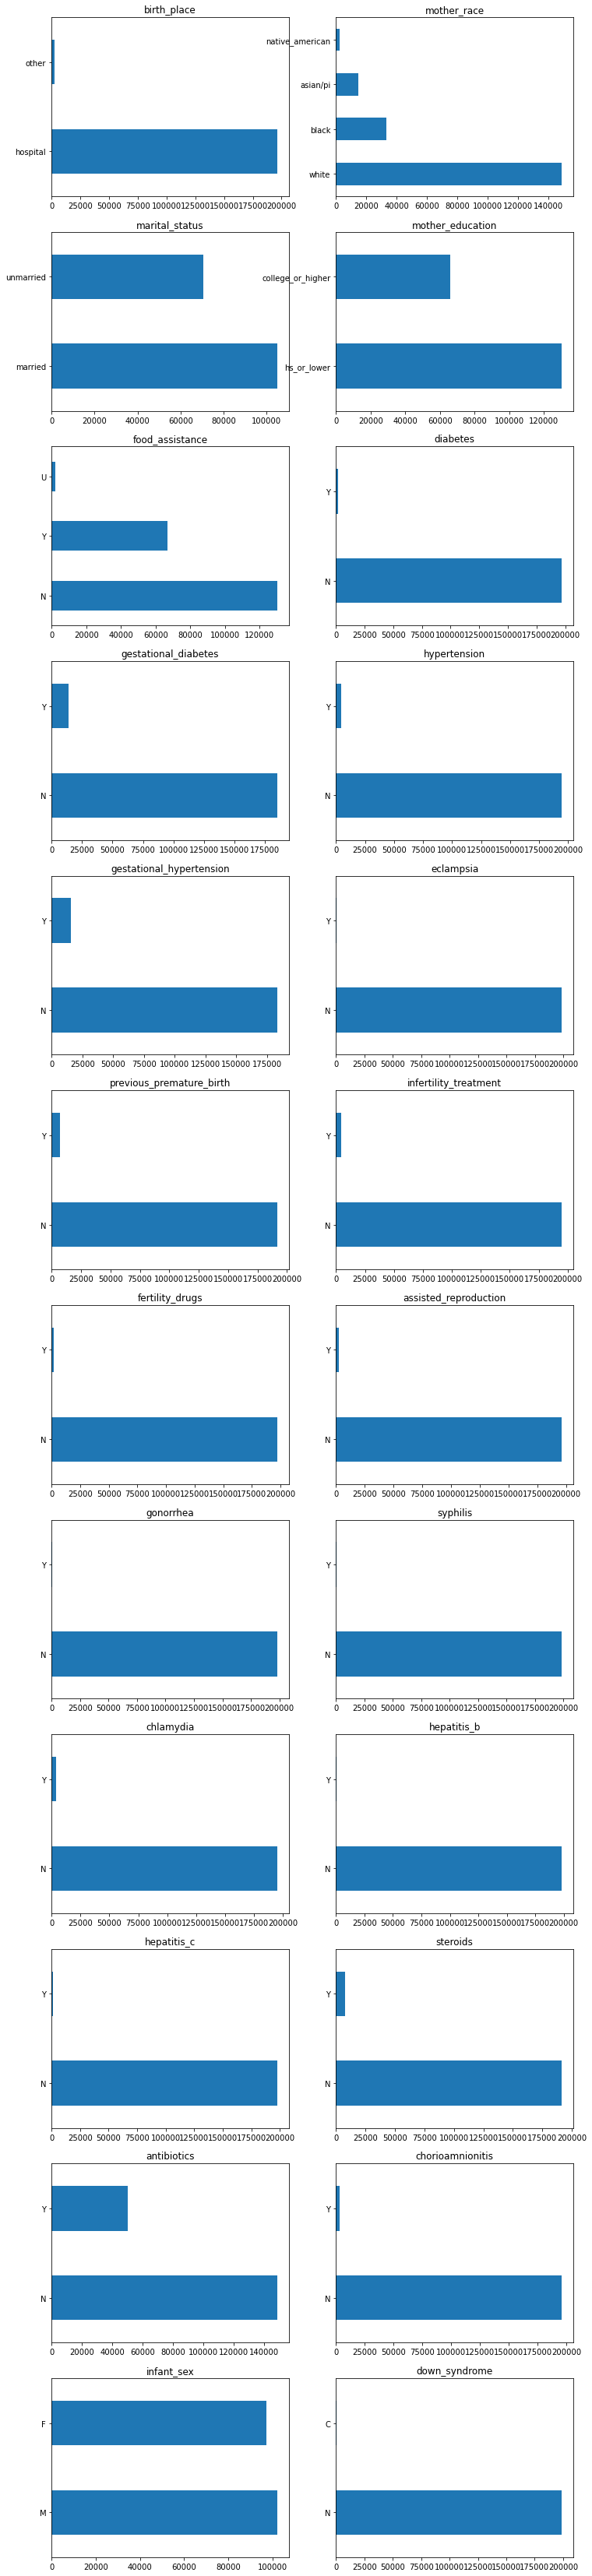

In [149]:
fig, axis = plt.subplots(nrows = int((len(df_cat.columns)/2)), ncols = 2, figsize=(12,len(df_cat.columns)*2.5))

for i, subplot in zip(df_cat.columns, axis.ravel()):
    df_cat[i].value_counts().plot(kind='barh', ax=subplot, title = i)

<ipython-input-150-db2104ea8bab>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=axis, bins='auto')


array([[<AxesSubplot:title={'center':'mother_age'}>,
        <AxesSubplot:title={'center':'mother_native'}>,
        <AxesSubplot:title={'center':'mother_hispanic'}>,
        <AxesSubplot:title={'center':'father_age'}>,
        <AxesSubplot:title={'center':'living_children'}>],
       [<AxesSubplot:title={'center':'deceased_children'}>,
        <AxesSubplot:title={'center':'terminations'}>,
        <AxesSubplot:title={'center':'months_prenatal_care'}>,
        <AxesSubplot:title={'center':'prenatal_visits'}>,
        <AxesSubplot:title={'center':'prepregnancy_daily_cig'}>],
       [<AxesSubplot:title={'center':'first_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'second_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'third_tri_daily_cig'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'delivery_weight'}>,
        <AxesSubplot:title={'center':'weight_gain'}>,
        <AxesSubplot:tit

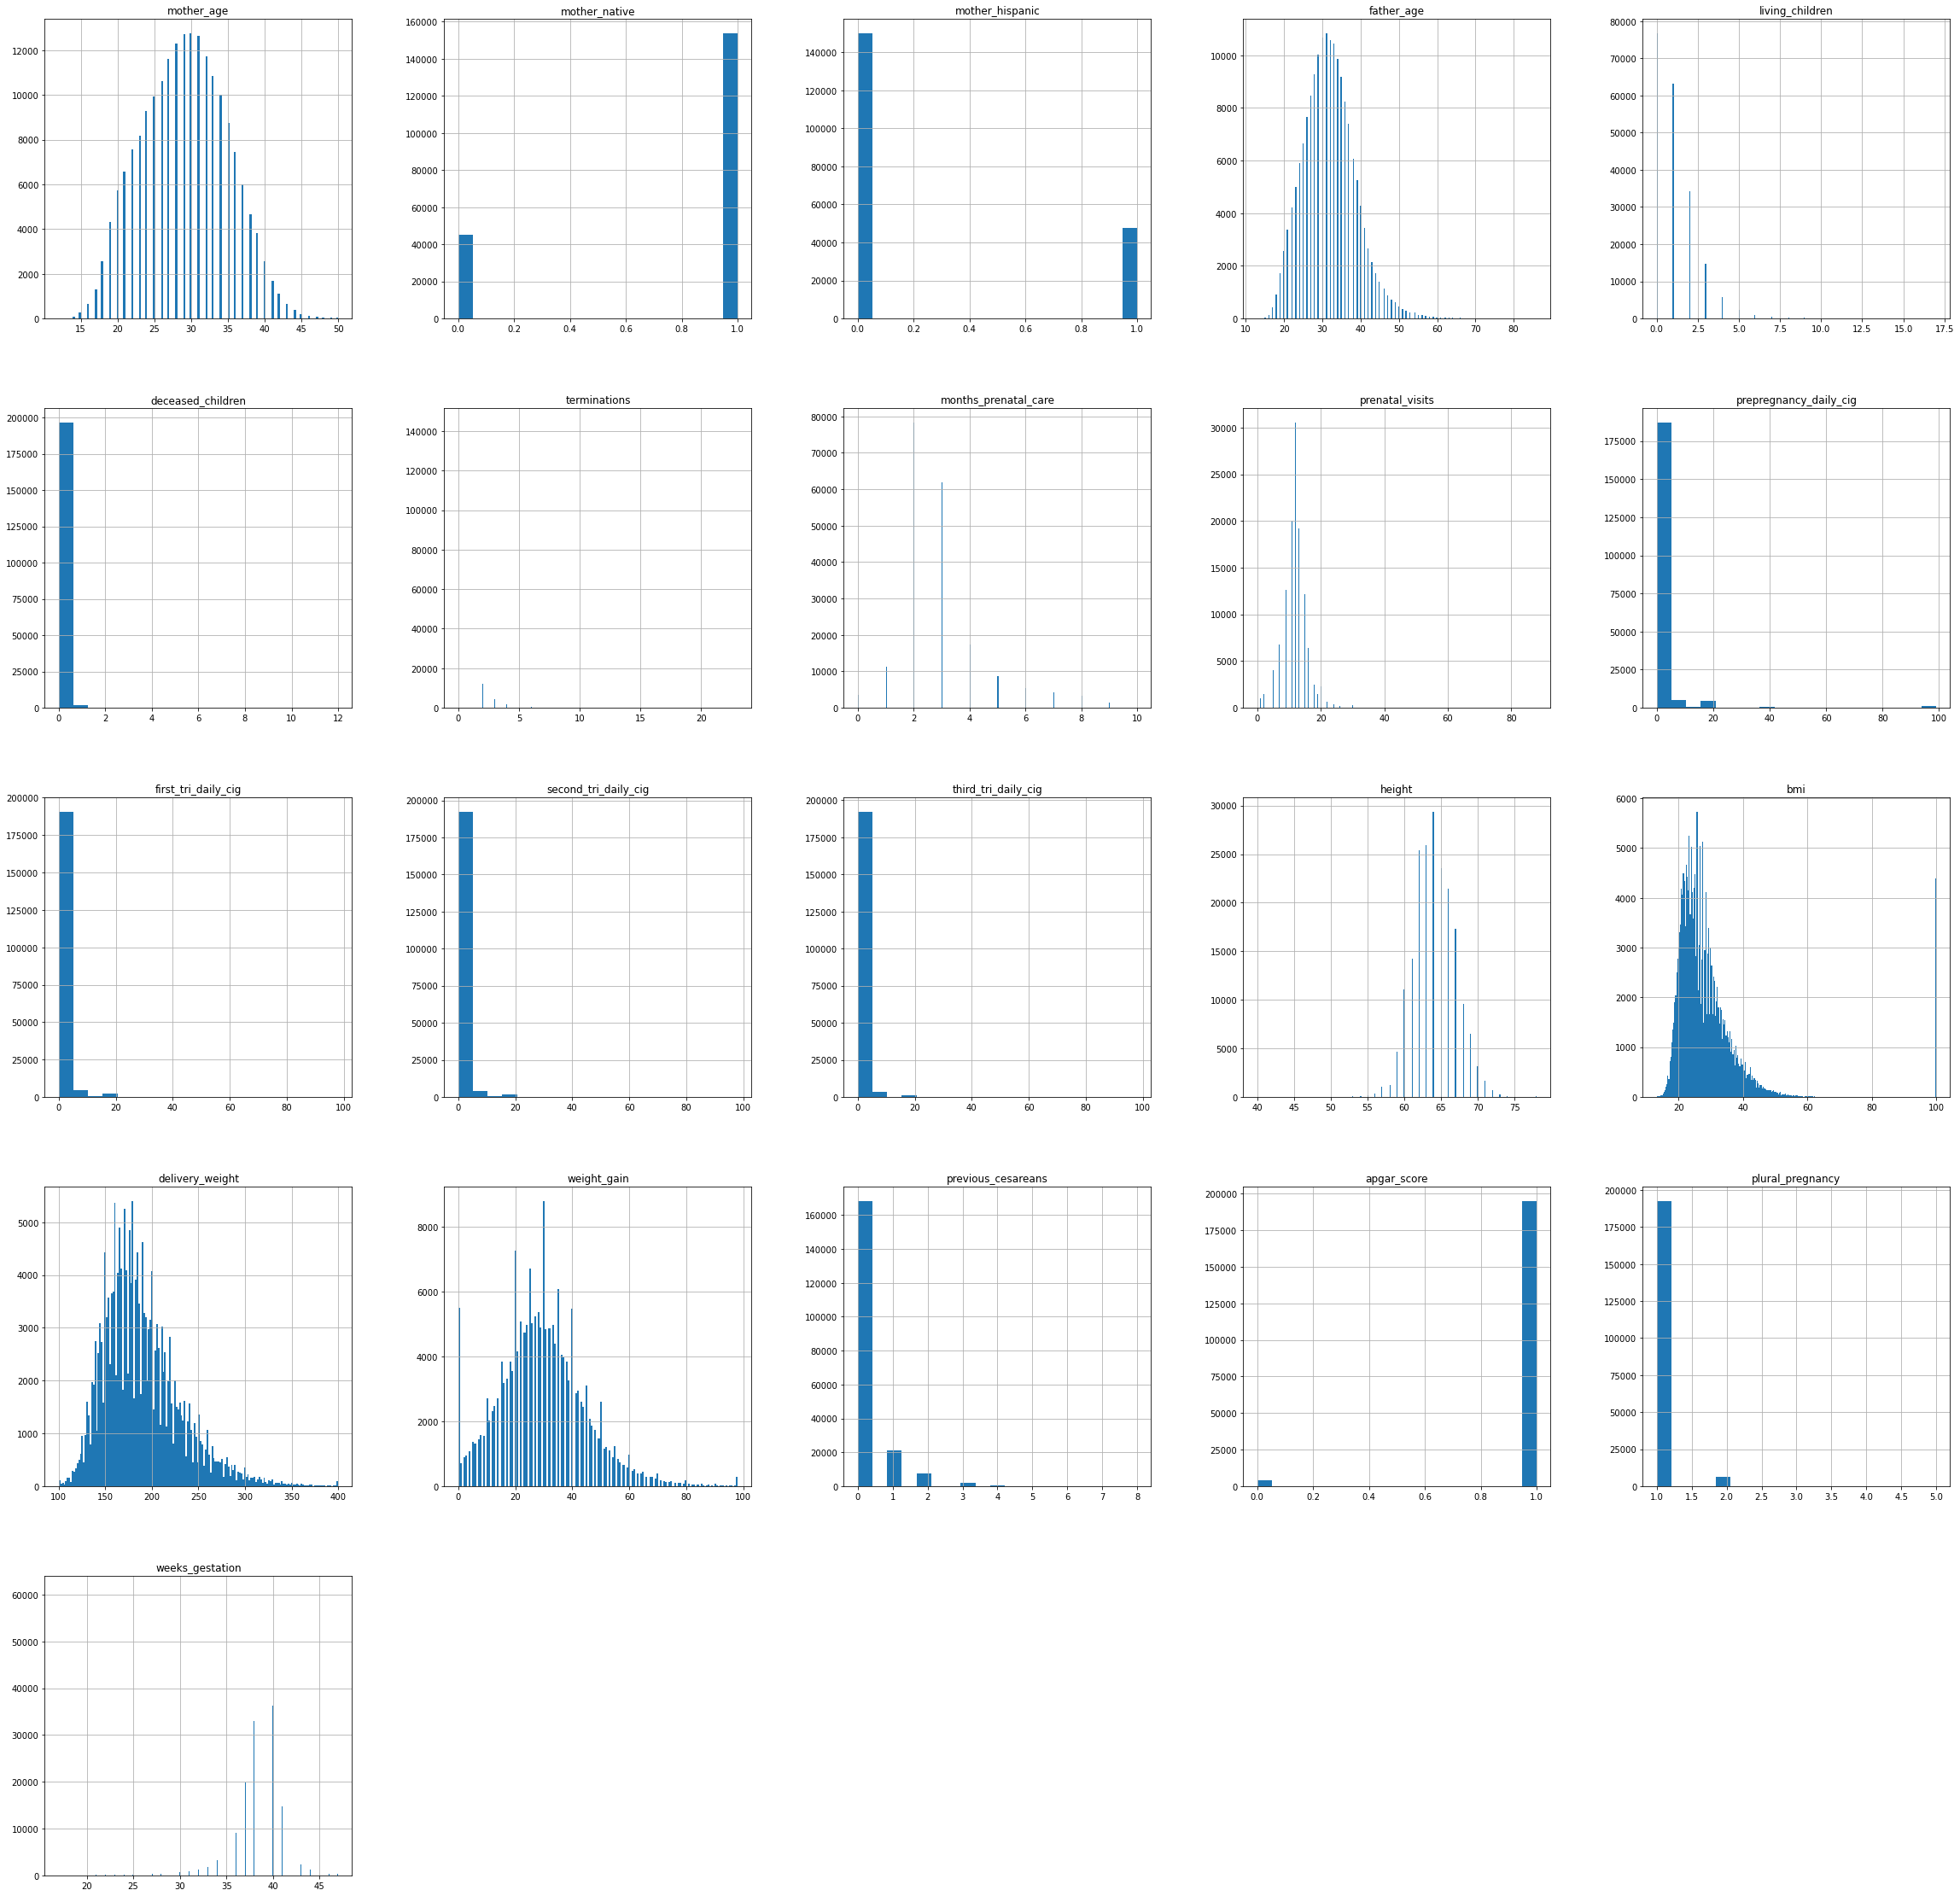

In [150]:
fig, axis = plt.subplots(figsize=(40, 40))
df.hist(ax=axis, bins='auto')

In [151]:
df.isna().sum()

birth_place                     6
mother_age                      0
mother_native                 412
mother_race                     0
mother_hispanic              1842
marital_status              23610
mother_education             2808
father_age                  22874
living_children               238
deceased_children             370
terminations                  409
months_prenatal_care         4385
prenatal_visits              4809
food_assistance                 0
prepregnancy_daily_cig          0
first_tri_daily_cig           942
second_tri_daily_cig          943
third_tri_daily_cig          1944
height                       1006
bmi                             0
delivery_weight              2618
weight_gain                  5712
diabetes                      111
gestational_diabetes          111
hypertension                  111
gestational_hypertension      111
eclampsia                     111
previous_premature_birth      111
infertility_treatment         111
fertility_drug

## Train Test Split

In [152]:
X = df.drop('apgar_score', axis=1)
y = df['apgar_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=27, stratify = df['apgar_score'])

In [153]:
X.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
       'down_syndrome'],
      dtype='object')

In [154]:
df_cat = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(include=['int64', 'float64'])

In [155]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [156]:
dummy_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DummyClassifier(strategy='most_frequent'))]
)

dummy_clf.fit(X_train, y_train)
print("Model score: %.3f" % dummy_clf.score(X_test, y_test))

model score: 0.979


In [159]:
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=27, max_iter=500))]
)

log_clf.fit(X_train, y_train)
print("Model score: %.3f" % log_clf.score(X_test, y_test))

Model score: 0.980
